🚨 **LangSmith 正在快速開發中，之後可能會增加更多功能或改變使用體驗**🚨

# 1. Tracking (紀錄)
這個很像傳統 MLOps 中的 Logging，都是為了 debugging 而紀錄中間的過程和產出。

## 1.1 Quick Start

In [3]:
from langchain_setup import ChatOpenAI, tracing_v2_enabled_if_api_key_set

with tracing_v2_enabled_if_api_key_set(project_name='tutorial') as cb:
    output = ChatOpenAI().predict("How many people live in canada as of 2023?")
    print(output)

I'm sorry, but as an AI language model, I don't have access to real-time data or the ability to predict the future. As of my last available data, in 2021, Canada's population was estimated to be around 38 million people. For the most accurate and up-to-date population figures, it would be best to refer to official sources like Statistics Canada or other reliable demographic databases.
[LangSmith URL]: https://smith.langchain.com/o/34ec837d-8405-462d-b949-fdfaebda792b/projects/p/fdcbda35-4d3a-418b-ab49-7e3205e630a6/r/b12fbc09-e8e7-4877-9595-257b7d2deb1f?poll=true


## 1.2 Tree structured stack trace

![stack trace.png](<attachment:stack trace.png>)

我們可以看到 LangSmith 紀錄了執行的堆疊追蹤 (stack trace)，並以樹狀的形式顯示:

**連結 (Edge)**
- 兄弟關係 (sibiling): 代表程序之間執行的順序（由上往下）
- 親子關係 (parent-child): 代表執行親程序 (parent) 的過程中呼叫了子程序 (child)

**節點 (Node)**
- 每個節點都是一個 Component (Prompt, Model, Output Parser, Retriever, Tool) 或 Runnable
- 顯示每個節點的輸入 (input) 和輸出 (output)，注意預設以 YAML 形式表示
- 每個節點都可以看到使用的 token 數和 latency，方便找出高昂費用或龜速的癥結點

## 1.3 Playground

除此之外，還可以直接從 stack trace 中直接做不同嘗試：
1. 點擊語言模型 (LLM / ChatModel) 的節點 (Node)
2. 點擊 "Open the Playground" 按鈕
3. 在這邊你可以調整模型的參數或更換不同模型
4. 點擊 "Start" 可以用新模型或設置，對該節點 (Node) 的輸入 (input) 得出結果

這個功能讓我們不用整個重跑，可以直接在線上的使用者介面上嘗試想探索不同可能性的步驟

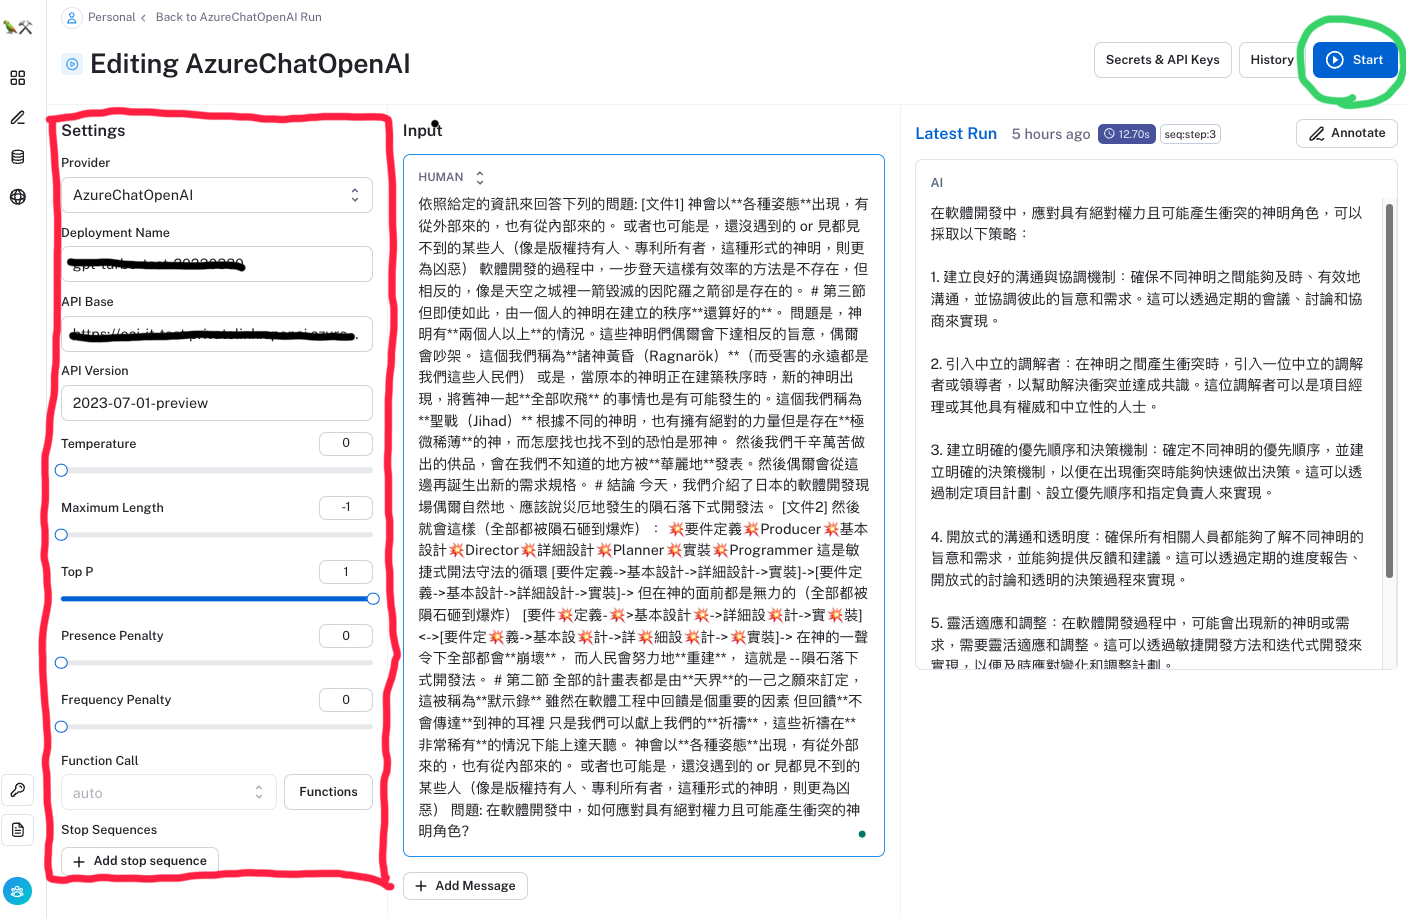
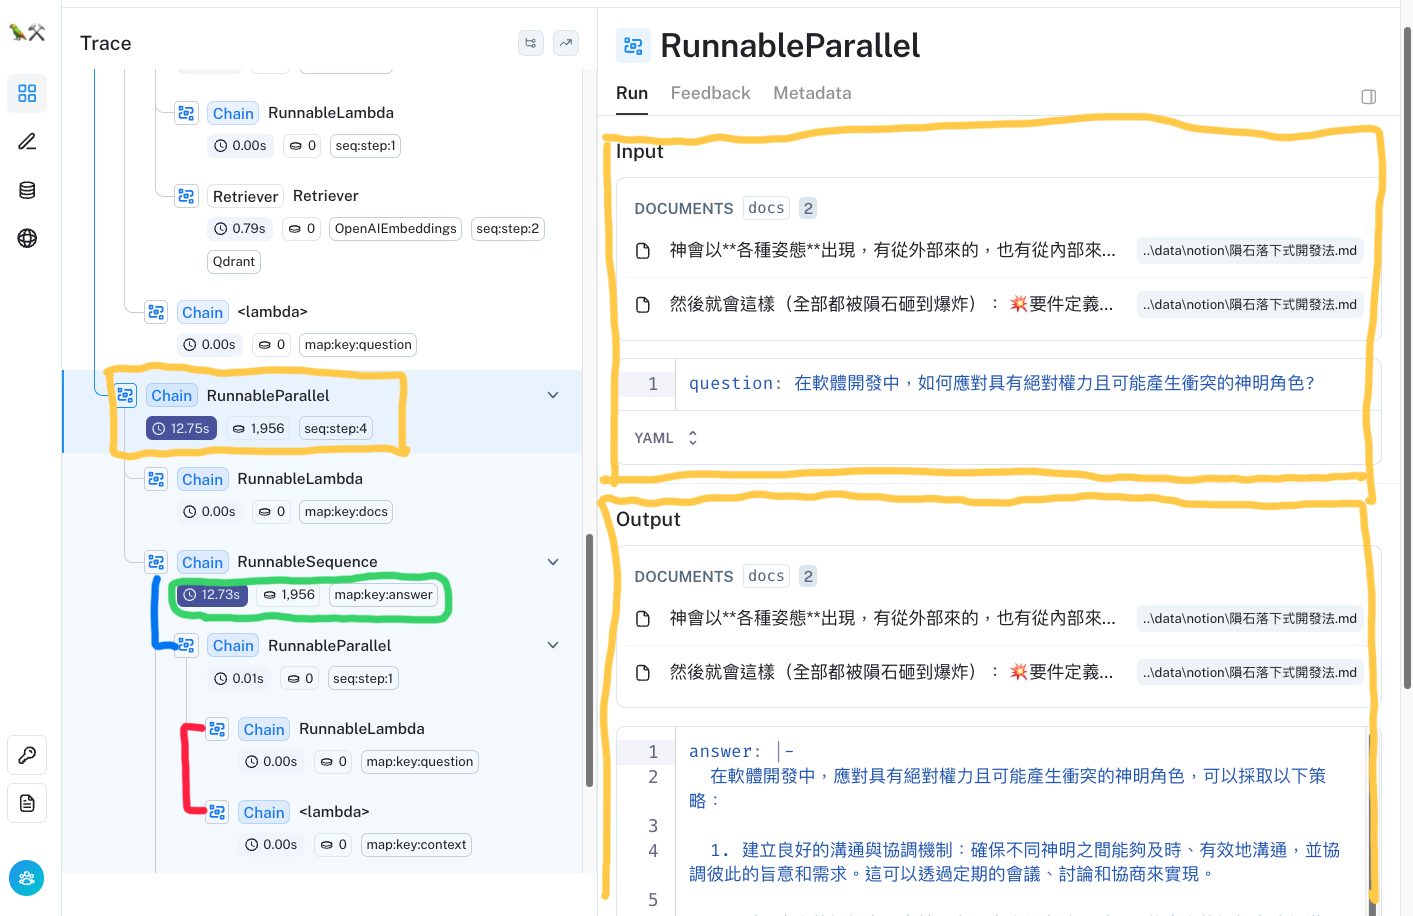

# 2. Data Collection（資料）

大量和高質量的資料集 (Dataset) 是評量效能 (Evaluation) 和訓練模型 (Training) 的基礎，進而為整個開發的基礎，因此如何收集資料成為重中之重。

## 2.1 Langchain 的 "Dataset"

**Examples**

Datasets & Testing -> \<dataset name\> -> Examples
- Input: 該筆資料的輸入
- Output: 相當於傳統生成式任務資料集的參考答案 (References)

**Dataset Type**
- Key value: dict -> dict
- Chat: messages -> messages
- LLM: 只包含一個對應到 str 的 key 的 dict -> 包含一個對應到 str 的 key 的 dict

## 2.2 資料收集
在新建一個資料集 (Dataset) 我們可以透過以下任一方式新增資料 (Example)
1. 手動新增：在該 Dataset 的網站頁面點擊 "Add Example"
    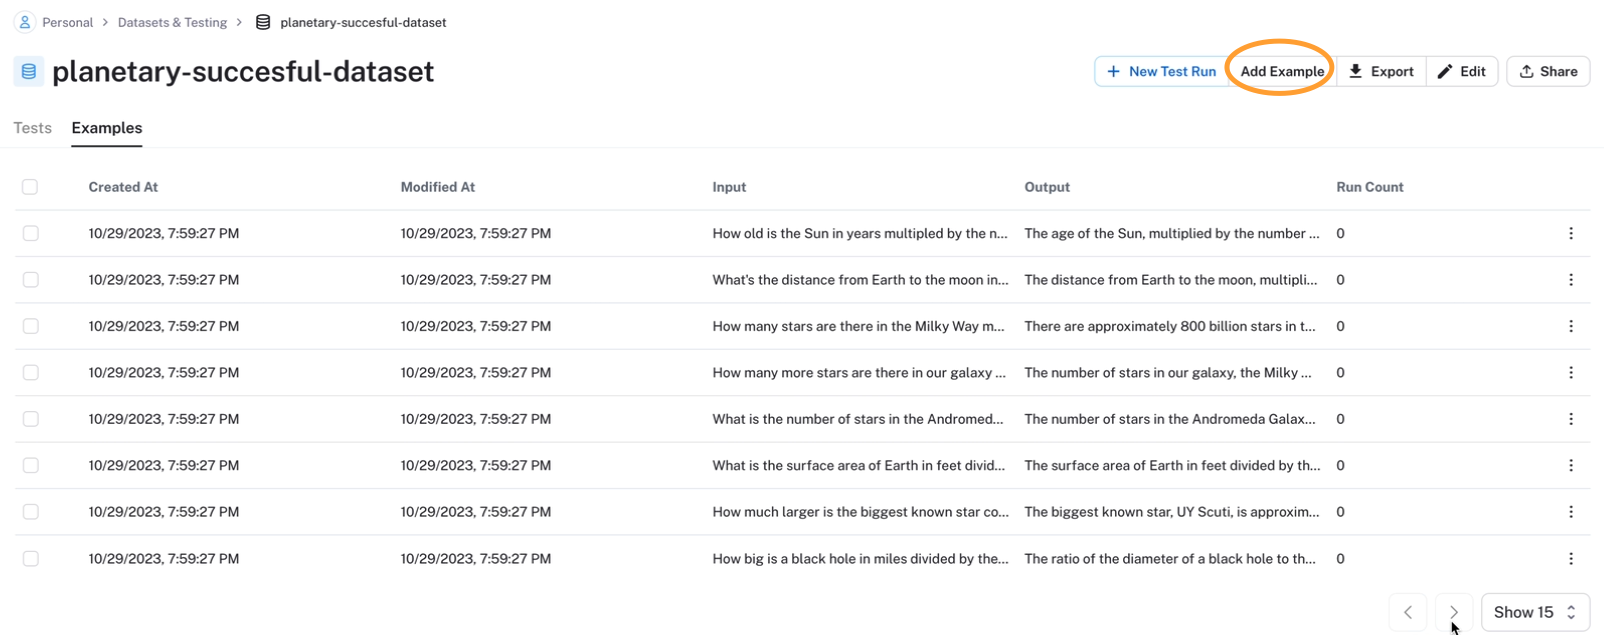
2. 程式新增：藉由 API 透過程式來新增
3. 透過 Annotation Queue：複選 Project 中的 traces 一次性加入 Annotation Queue，在 Annotation Queue 中修改 input / output 後選擇 "Add to Ｄataset" 加入修改後的資料 (Example)，並點選 "Done" 來編輯下一筆資料。這種方法的好處在於只需要修改，無須從頭編輯。
    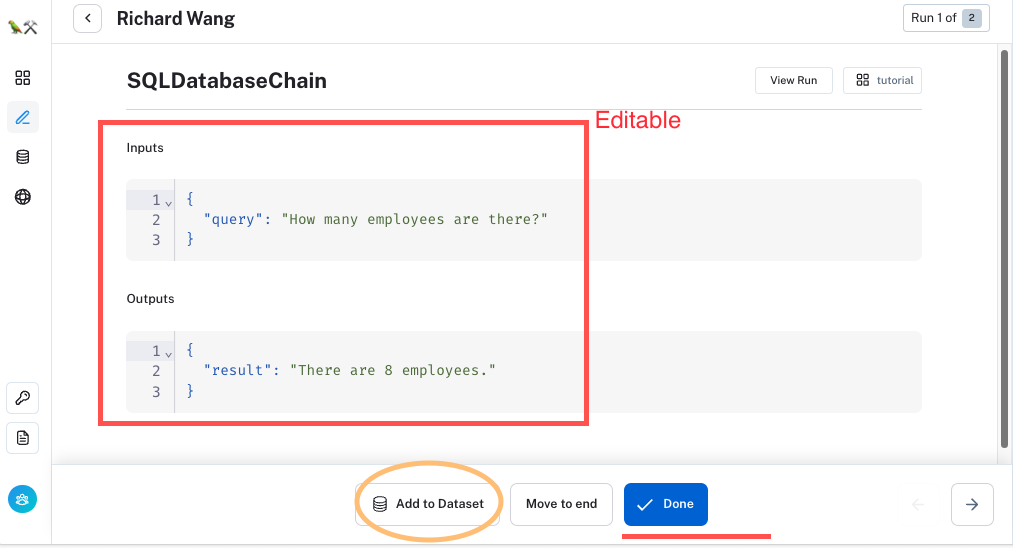
4. 直接匯入 traces: 複選 Project 中的 traces 一次性加入 Dataset。這種方法的用處在於你想要把某個模型 (如 GPT4) 的輸出，直接地當作高度正確的參考答案。

# 3. Evaluation
## 3.1 Automatic Evaluation
雖然在生成式應用中常常沒有單一標準答案造成很能直接跟參考答案比較，但是人工評量還是太費時費工，所以大家還是開發了多種自動評量的方式。

傳統上來說有 BLEUScore 這種靠統計來計算的指標，也有 BertScore 這樣使用到語言理解模型 (NLU Model) 來計算的指標，但都是計算與參考答案間的相似度。

新興的方式是準備一個比受測模型更強大的語言生成模型 (Generative Model) ，例如 GPT-4，並將它當成人類專家直接詢問受測模型輸出的質量如何，這個方式不一定需要參考答案，也不一定只能問正不正確，譬如問回答有沒有創意也是可以的。其評量結果會是『評測項目』和『評測分數』，而這個『評測項目』在 Langchain 就是以 "feedback" 表示。

在 Langchain 中自動化評量通常照下列步驟
1. [Datasets & Testing] -> [\<dataset name\>] -> [Tests] -> [Create Test Run] 
2. 從所提供現成的評測項目中選擇
3. 複製隨之自動產生的程式碼
4. 修改程式碼，將受測的 Model/Chain/Runnalbe 改成自己的 Model/Chain/Runnalbe
5. 執行程式碼
6. 結束後我們可從該 Test Run 上得到各個評測項目的評測分數平均 (所有該 dataset 的 examples 的該項目分數的平均)
![evaluation result.png](<attachment:evaluation result.png>)

幾點額外補充
- 除了使用生成語言模型和現成的評測項目外，你也可以自己客製化 (customize) 自己的評測項目 (evaluator)，且不一定需要用到生成語言模型。
- 沒有辦法做複雜的分數整合 (aggregation)，例如算出 F1 Score。但可以分別紀錄 TP, FP, TN, FN 後自行計算

## 3.2 Human Evaluation

雖然人工評測成本很高，但還是最準的方法。但在 Langchain 上，目前似乎還不能直接把 Dataset 直接送到 Annotation Queue 做人工評測。當前的替代方法是
1. 先使用自動化評測的步驟建立一個 Test Run
2. 進入該 Test Run 並將所有 traces 選取
3. "Send to Annotation Queue"
4. 在 Annotation Queue 中編輯評測項目 (feedback) 和其分數
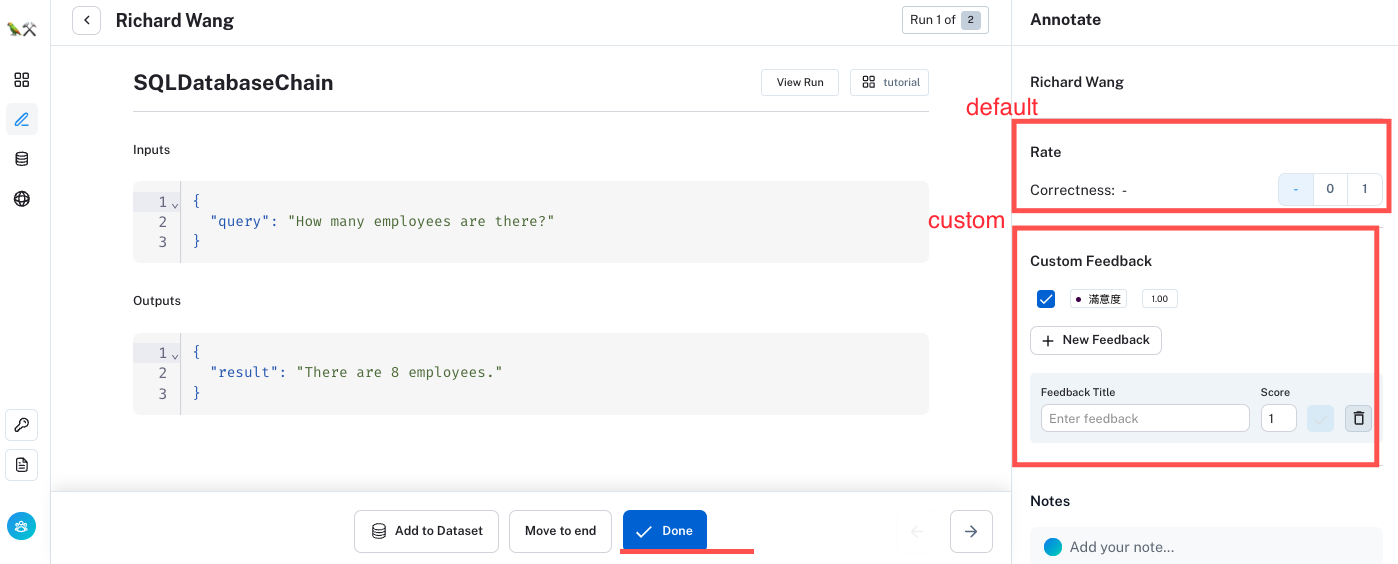

## 3.3 Error Analysis
除了宏觀地 (Macro-level) 看整體的表現，大量觀察個別 Example 的表現 (Micro-level) ，特別是表現不好的 Examples，是發現問題癥結點的重要手段。Langchain 提供兩種不同的查看方式

1. Stack Trace View

    1-1 點進 [Datasets & Testing] -> [\<dataset name\>] -> [Tests] -> [\<test run name\>] 後可以看到在每個 Example 上得到的評測分數
    1-2 找到想要查看的 trace 點進去後，就是上面介紹的樹狀堆疊追蹤。

2. Comparison View

    2-1 [Datasets & Testing] -> [\<dataset name\>] -> [Tests] 
    2-2 勾選一或複數個 test run
    2-3 選擇 "Compare"
    2-4 可以看到在同樣的 input 下，不同的 Test Run 和參考輸出 (reference output) 的結果的比較列表。
    ![comparison table-2.png](<attachment:comparison table-2.png>)
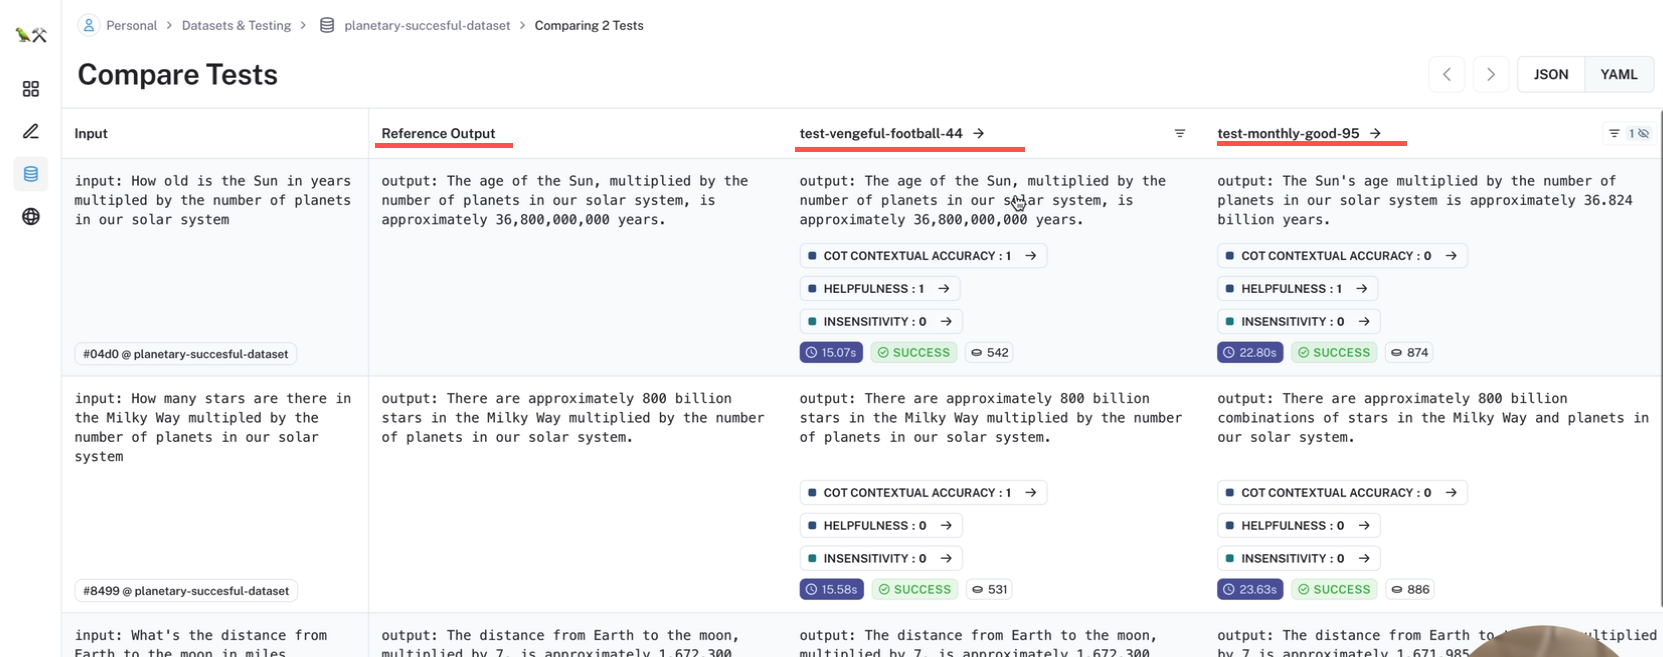
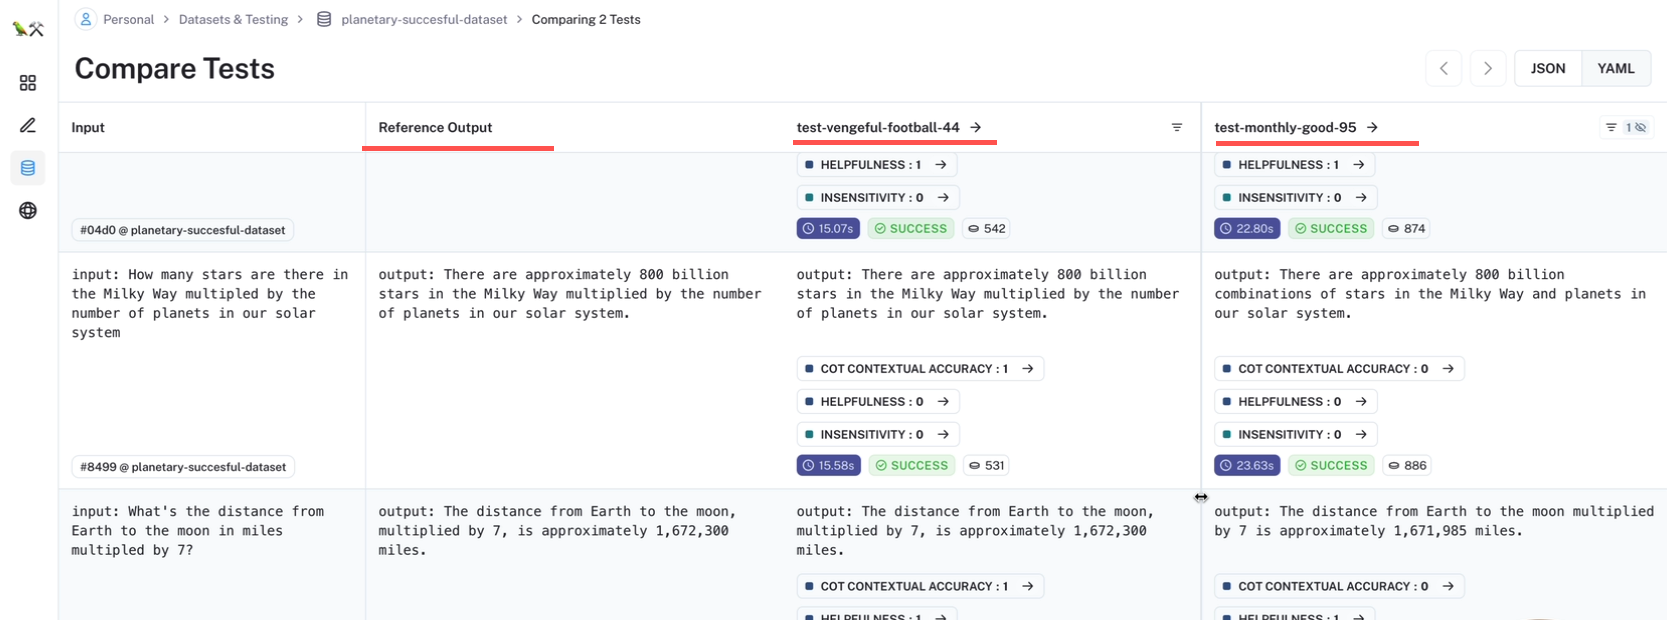
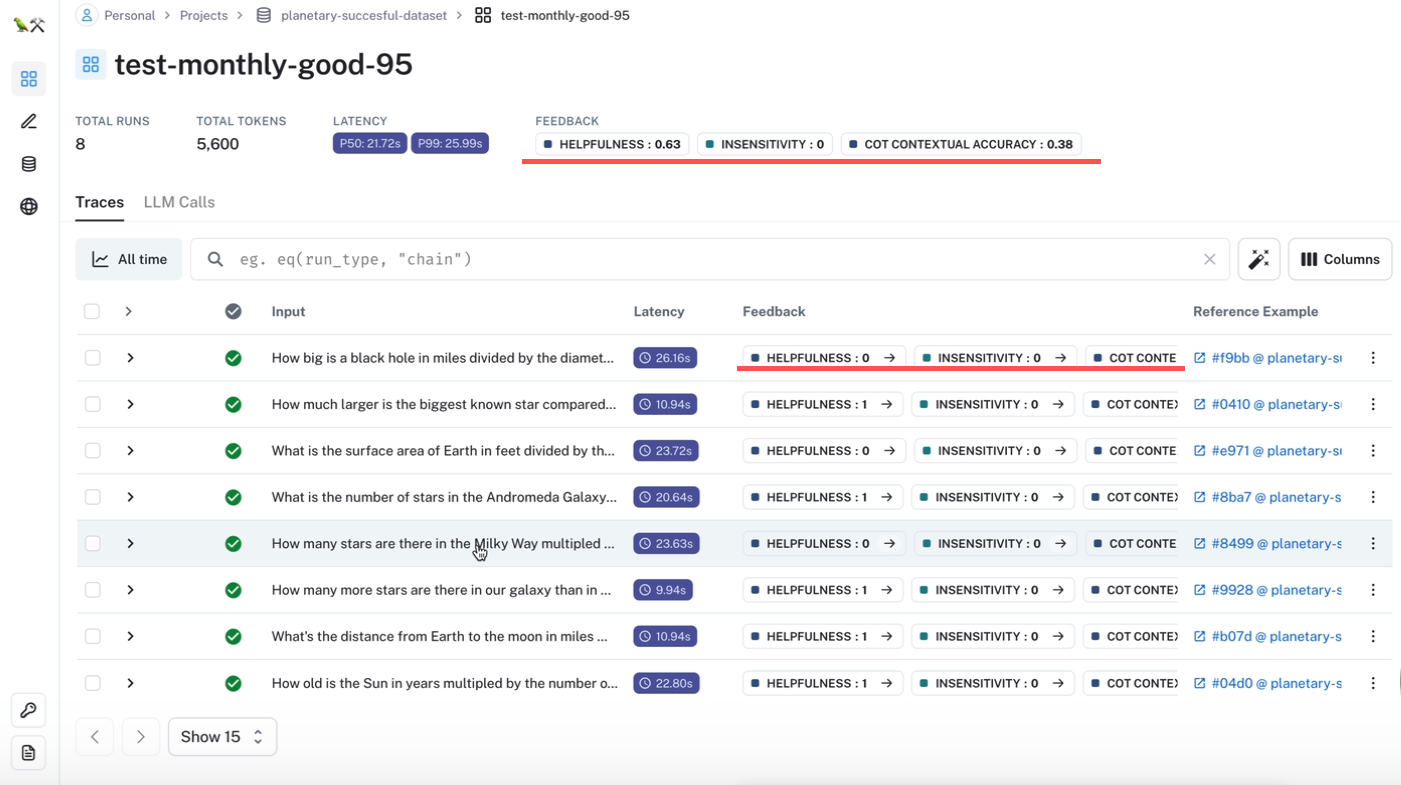

# Monitoring
當我們的應用實際上線後，並不是就不用管了，還要監督其後續表現得好不好，有沒有花掉我們太多資源等等。持續的監督 (monitoring) 才能發現問題並改進問題。在這方面，我們不需要特別做什麼，Langsmith 會幫我們處理好，我們只需要看結果就可以了。

進入 Projects -> [\<project name\>] -> Monitor 可以看到有數個區塊

## Feedback （表現）
顯示隨著時間推移的評測項目的分數。其意義在於如果分數在某段時間突然表很低，或著表現逐漸下滑，我們就得去找問題在哪裡。

而這邊的評測項目要靠我們應用的設計，讓我們將使用者跟應用的互動轉化為回饋 (feedback) 的分數後，透過 LangSmith 的 API 傳送到後台。

例如我們可以透過設計應用與使用者的互動，來將使用者的回饋化成分數。例如在應用中設計讚和倒讚的按鈕，試用者按了讚/倒讚就是 1/-1，沒按就是 0，並把這個數值叫做『滿意度』透過 LangSmith 的 API 回傳。則我們可以看到各個 trace 會被帶有滿意度的分數，並在 Monitor 的 feedback 區塊可以監控隨著時間推移下平均滿意度的變化。

## 速度 (Latency, Streaming)
- Latency
    - Trace Latency: 跑完整個程序需要的時間
    - LLM Calls per Trace: 如果跑完程序很久，可以看這項指標來看是不是每個程序呼叫了太多次語言模型
    - ...
    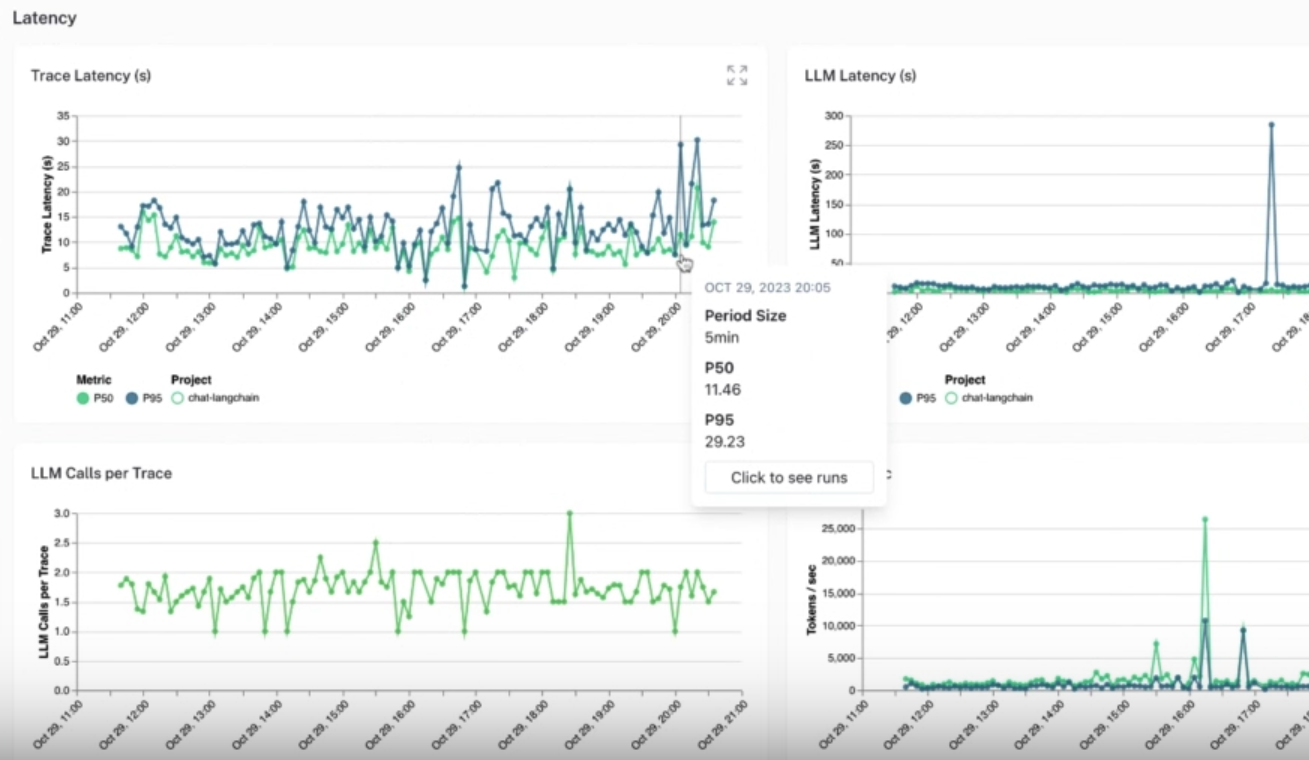
- Streaming
    - Time to first token: 到給使用者回答的第一個字需要的時間
    - ...
    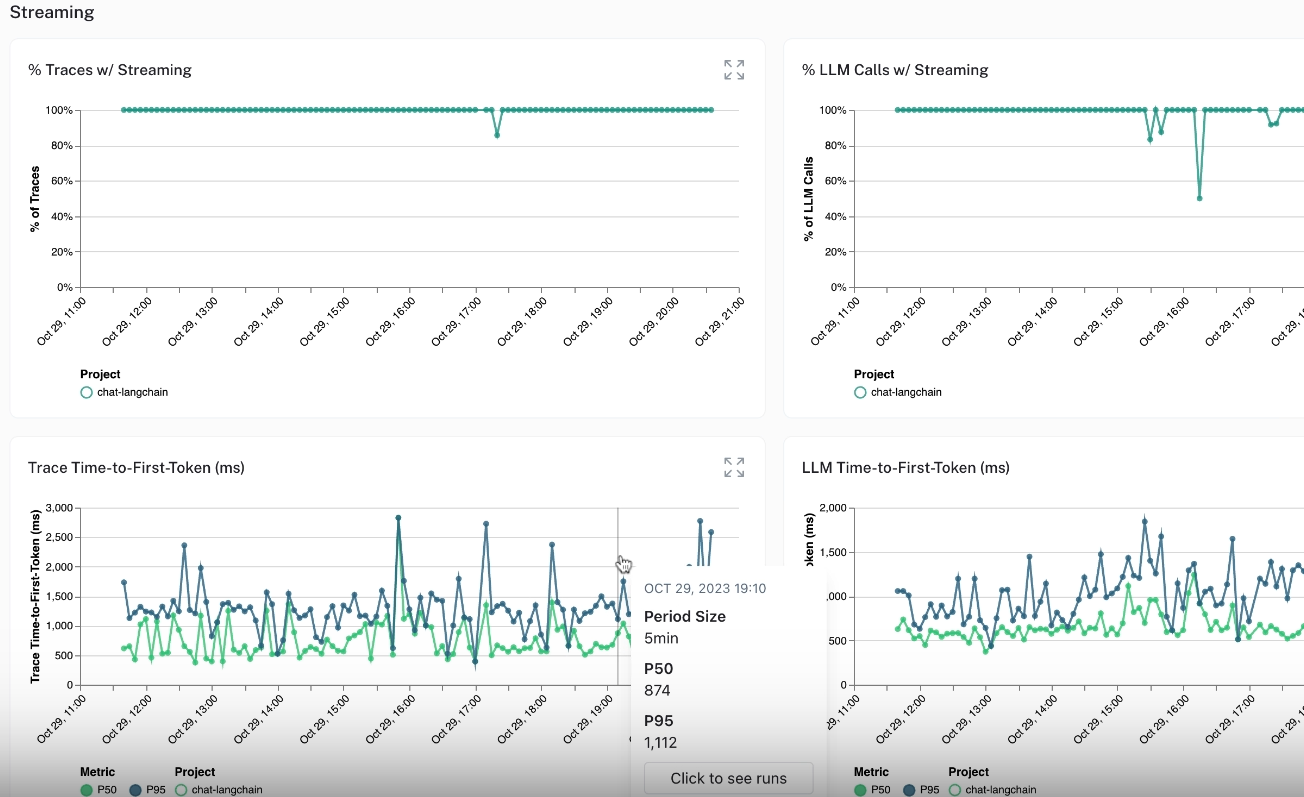

## 資源使用情形 (Tokens, Volume)
- Volume
    - Trace Count: 如果整個語言模型應用程序紀錄為一個 trace，透過這個可以知道我們語言模型應用被使用的次數多不多。
    - Trace Success Rates: 監測是否有很多失敗的執行
    - ...
- Tokens
    - Total tokens: 花費了多少 tokens，也就是花費了多少錢
    - Token per Trace: 每執行一個程序平均花多少 tokens
    - Tokens per LLM Call: 如果發現花太多 tokens，可以看這個指標來判斷是每個 LLM 呼叫花太多還呼叫太多次 LLM
    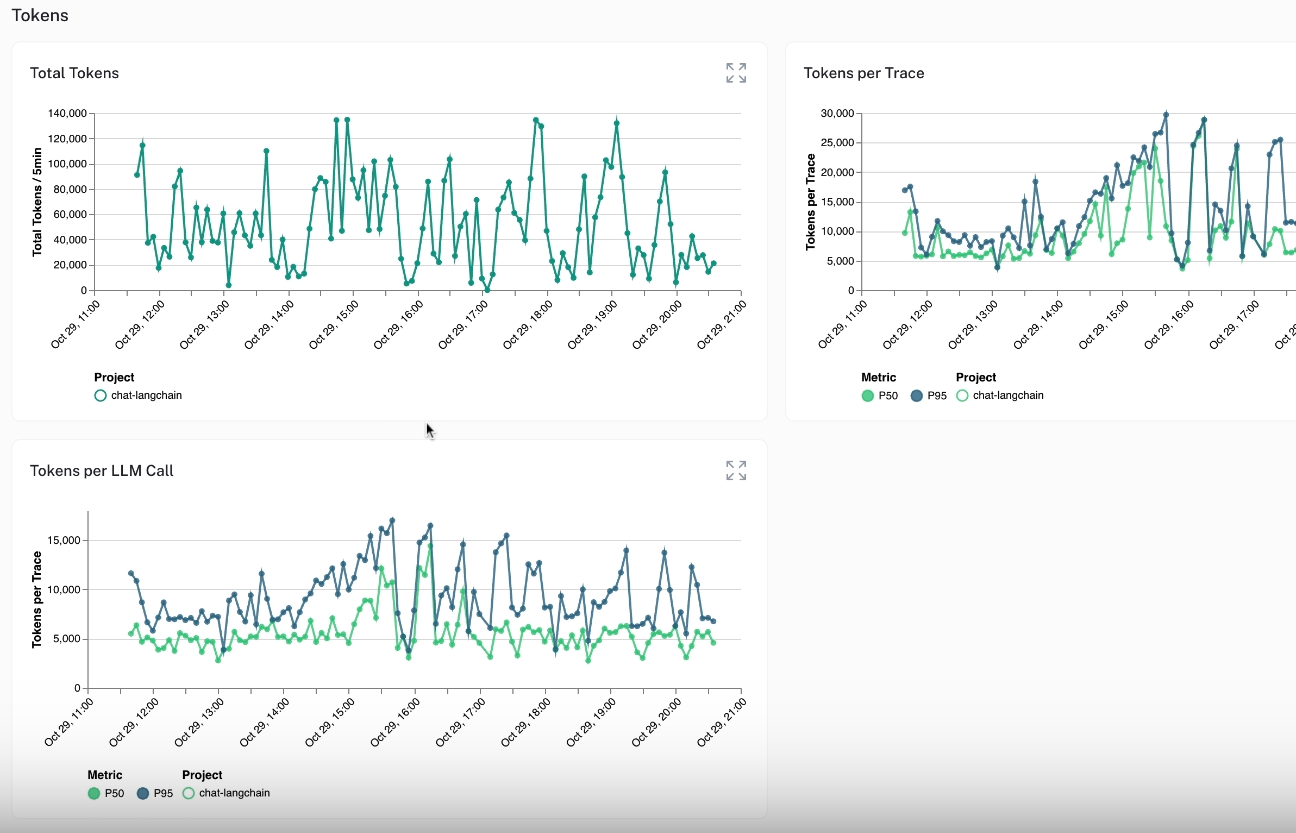